# Test two-point correlation function

This notebook shows examples of calculating the two-point correlation function, initially for light profiles. This can also be applied to mass profiles, or residuals, in fact, any 2D field. It uses the `Analysis` class to compute effective quantities in a model-independent way.

_Note: this notebook is aiming to reproduce fig. 3 from Vernardos et al. (2020)._

__authors__: @gvernard, @aymgal

__created on__: 14/07/23

__last update__: 20/07/23

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm

from coolest.api.analysis import Analysis
from coolest.api.plotting import ModelPlotter
from coolest.api import util

In [2]:
def print_info(coolest_object):
    source_index = 2  # index of the source galaxy in the list of `lensing entities`
    print("Lensing entities:", [type(le).__name__ for le in coolest_object.lensing_entities])
    print("Source light model:", [type(m).__name__ for m in coolest_object.lensing_entities[source_index].light_model])

## Load light models stored in COOLEST format

We are loading three profiles, the ones used in Vernardos et al. (2020), from a single COOLEST file. The actual role of these profile (lens light, source, etc) doesn't matter.

In [3]:
input_path = 'database/two-point/two_point'
coolest = util.get_coolest_object(input_path, verbose=True, check_external_files=False)
print_info(coolest)

Failed reading with jsonpickle, trying reading pure json (original error: [Errno 2] No such file or directory: '/Users/aymgal/Science/packages/my_packages/coolest/docs/notebooks/database/two-point/two_point_pyAPI.json')
Lensing entities: ['Galaxy', 'Galaxy', 'Galaxy']
Source light model: ['PixelatedRegularGrid']


## Setup custom coordinates

so that we can evaluate light profiles consistently on that specific coordinates grid. 

In [4]:
coord_orig = util.get_coordinates(coolest)
x_orig, y_orig = coord_orig.pixel_coordinates
print(coord_orig.plt_extent)

# coord_src = coord_orig.create_new_coordinates(pixel_scale_factor=0.1, 
#                                               grid_center=(0.6, 0.7), 
#                                               grid_shape=(1.42, 1.42))
# x_src, y_src = coord_src.pixel_coordinates
# print(coord_src.plt_extent)

[-2.96, 2.96, -2.96, 2.96]


## Show the galaxies

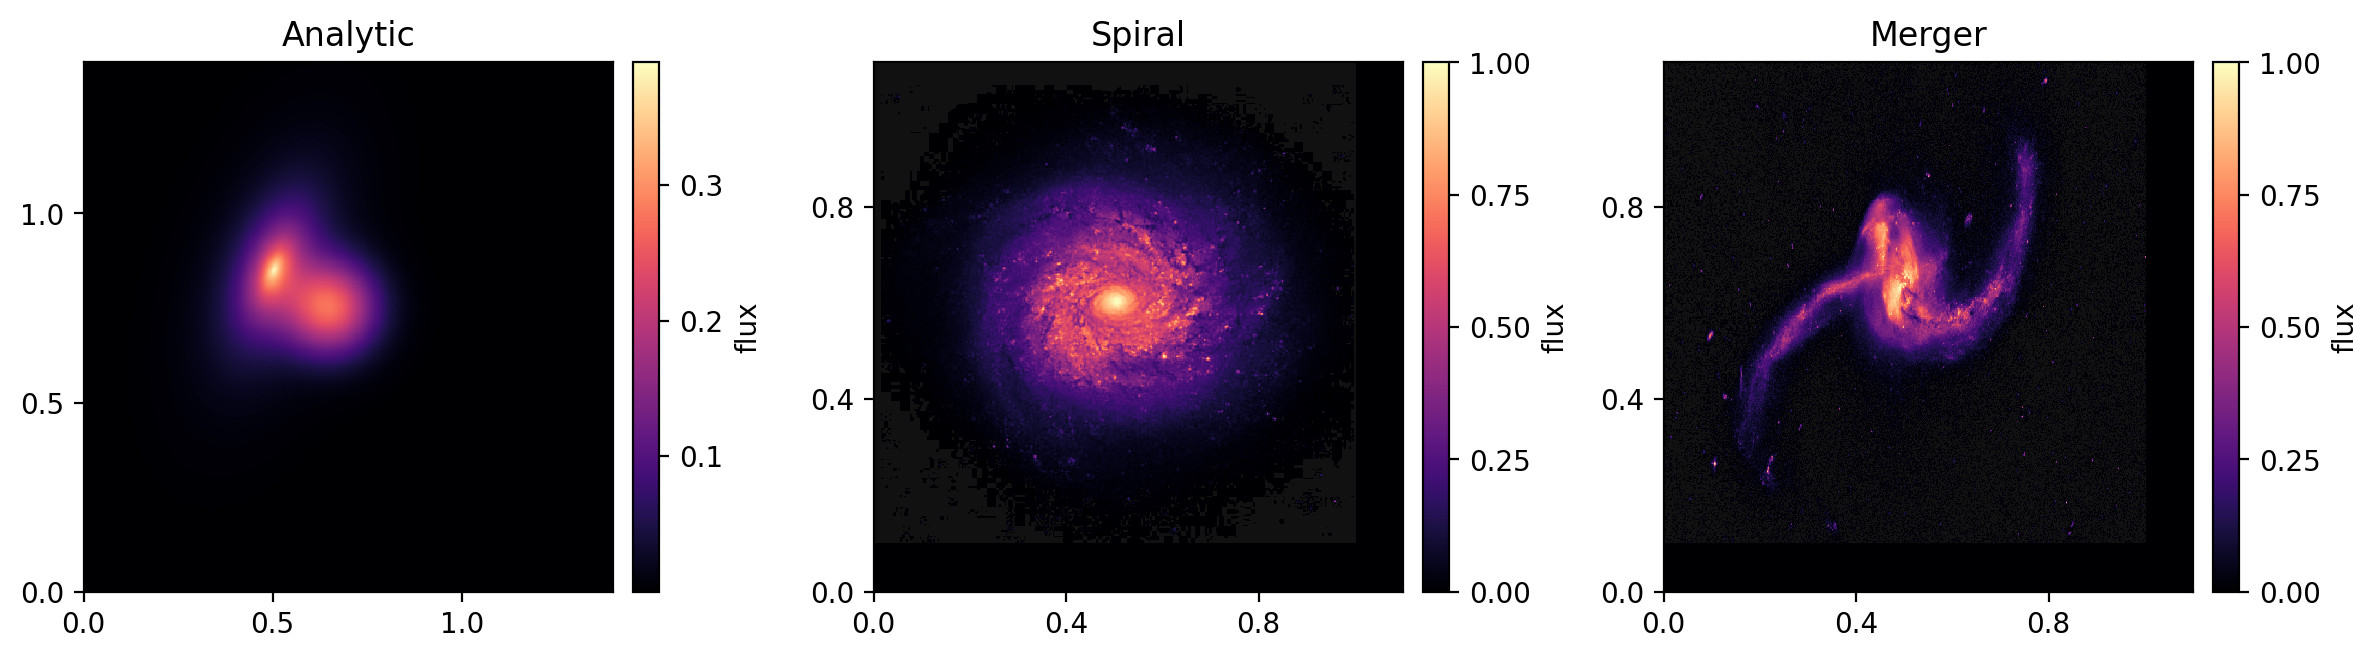

In [5]:
plotter = ModelPlotter(coolest, input_path)
norm = None #Normalize(-0.005, 0.4)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for entity_idx, (ax, title) in enumerate(zip(axes, ["Analytic", "Spiral", "Merger"])):
    plotter.plot_surface_brightness(
        ax, title=title,
        # coordinates=coord_src,
        kwargs_light=dict(entity_selection=[entity_idx]),
        norm=norm,
        neg_values_as_bad=True,
    )
plt.tight_layout()
plt.show()

## Compute and plot the two-point correlation function

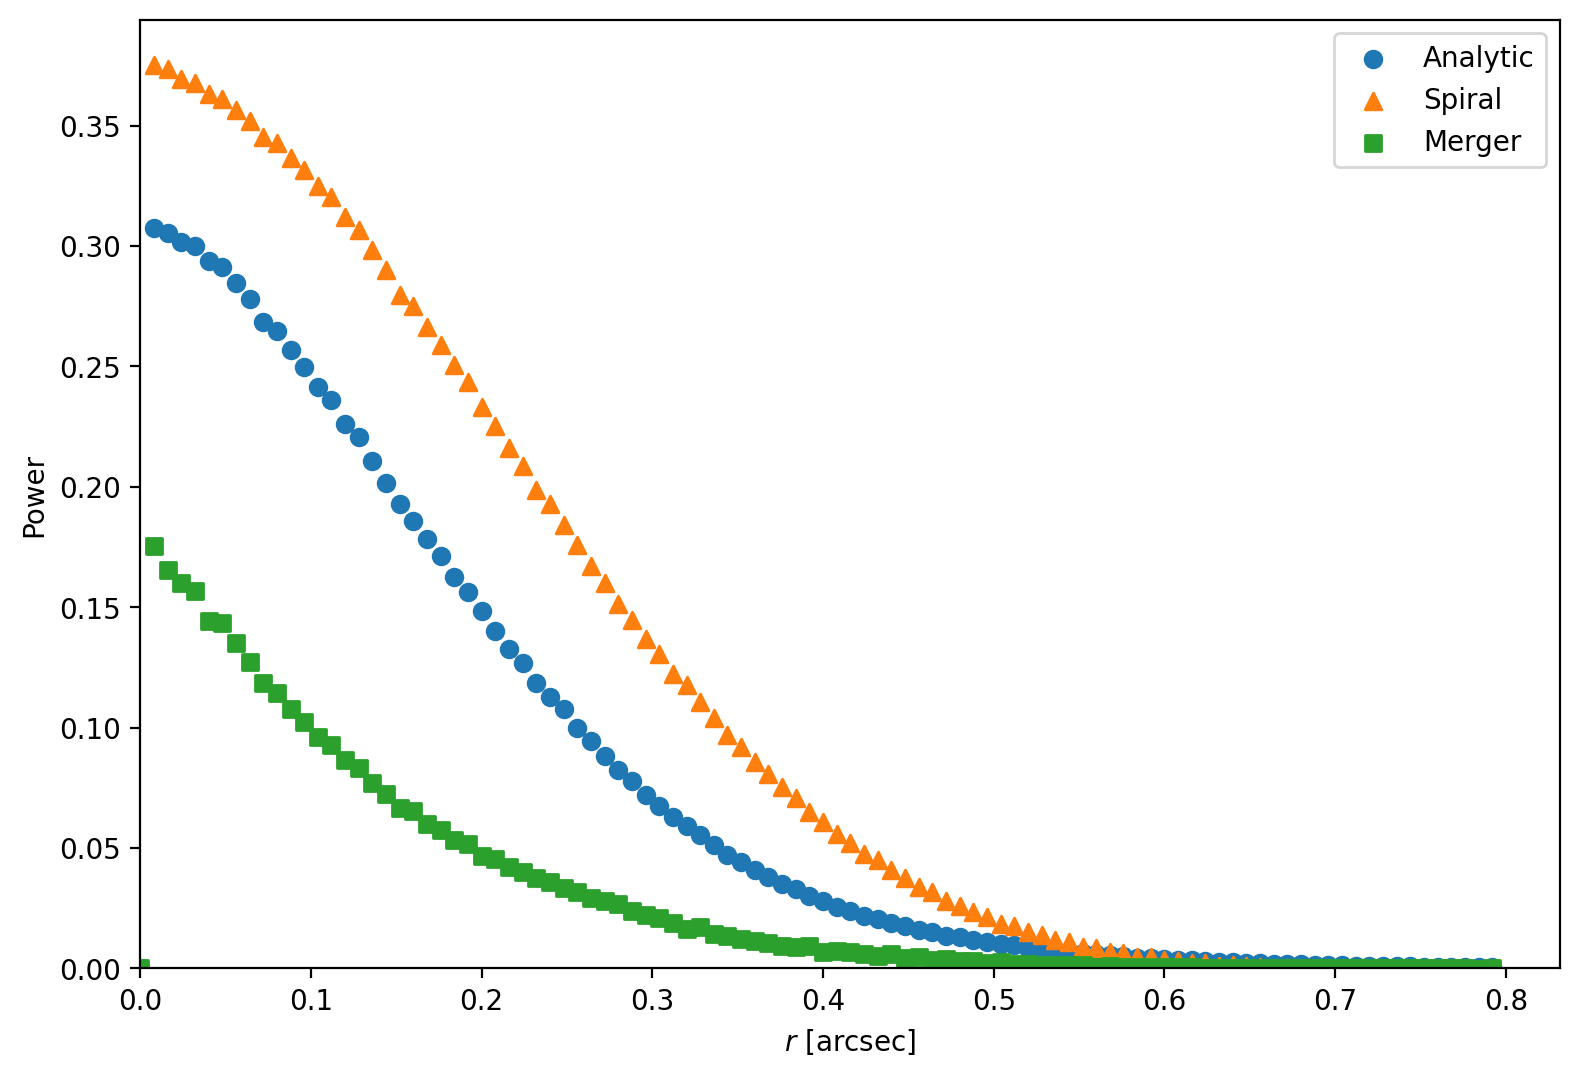

In [6]:
analysis = Analysis(coolest, input_path, supersampling=5)

# Analytic profile
x0, y0, err0 = analysis.two_point_correlation(rmax=0.8, normalize=True, entity_selection=[0], 
                                              use_profile_coordinates=True)

# Spiral galaxy
x1, y1, err1 = analysis.two_point_correlation(rmax=0.8, normalize=True, entity_selection=[1],
                                              use_profile_coordinates=True)

# Merger
x2, y2, err2 = analysis.two_point_correlation(rmax=0.8, normalize=True, entity_selection=[2],
                                              use_profile_coordinates=True)


# This is to normalize the curves to their maximum in order to obtain exactly the same figure as fig. 3 in Vernardos et al. (2020)
#y0 /= np.amax(y0)
#y1 /= np.amax(y1)
#y2 /= np.amax(y2)


fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))

ax.scatter(x0,y0,marker='o',label="Analytic")
ax.scatter(x1,y1,marker='^',label="Spiral")
ax.scatter(x2,y2,marker='s',label="Merger")

ax.set_xlabel(r"$r$ [arcsec]")
ax.set_ylabel(r"Power")

ax.legend()
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
fig.tight_layout()
plt.show()